# Introduction to ensembling/ stacking in python for titanic disaster dataset

Link to the thread : https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python

In [1]:
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier,
            GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold

Feature Exploration, Engineering and Cleaning

In [2]:
# load the datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

#store passengerid for easy access later
PassengerId = test['PassengerId']

train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
data= pd.concat( [train, test] )
print(train.shape)
print(test.shape)
print(data.shape)

(891, 12)
(418, 11)
(1309, 12)


In [4]:
data.reset_index(drop = True, inplace=True)
#data.drop(['index'], axis=1, inplace=True)
#data
print(data.columns)

#for now we will drop PassengerID as well
data.drop(['PassengerId'], axis=1, inplace=True)

data

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
1304,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


Feature Engineering

In [5]:
# Creating some new features and change some categorical to numerical features

data['Name_length'] = data['Name'].apply(len)
data['Cabin'] = data['Cabin'].fillna(value='C0')
data['Cabin'] = data['Cabin'].str.replace(r"[C]", "")
data['Has_Cabin'] = 1
data.loc[ data['Cabin']=='0', 'Has_Cabin' ] = 0

In [6]:
data

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_length,Has_Cabin
0,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,0,S,23,0
1,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,85,C,51,1
2,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,0,S,22,0
3,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,123,S,44,1
4,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,0,S,24,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,0,S,18,0
1305,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,105,C,28,1
1306,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,0,S,28,0
1307,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,0,S,19,0


In [7]:
#data.drop(['Cabin'], axis=1, inplace=True)
data['FamilySize'] = data['SibSp']+ data['Parch'] + 1
data['isAlone'] = 0
data.loc[ data['FamilySize']==1, 'isAlone' ] = 1
#data.drop(['SibSp', 'Parch'], axis=1, inplace=True)

In [8]:
data
# Nextup we clean the features of their NaN values

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_length,Has_Cabin,FamilySize,isAlone
0,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,0,S,23,0,2,0
1,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,85,C,51,1,2,0
2,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,0,S,22,0,1,1
3,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,123,S,44,1,2,0
4,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,0,S,24,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,0,S,18,0,1,1
1305,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,105,C,28,1,1,1
1306,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,0,S,28,0,1,1
1307,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,0,S,19,0,1,1


In [9]:
data.isnull().sum()

Survived       418
Pclass           0
Name             0
Sex              0
Age            263
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin            0
Embarked         2
Name_length      0
Has_Cabin        0
FamilySize       0
isAlone          0
dtype: int64

In [10]:
# Binning fare values
#pd.qcut(train['Fare'], 4)


#data.Embarked.value_counts()

In [11]:
#np.random.randint( 5-2,5+2, 250 )
#data['Age'][np.isnan(data.Age)]
#pd.qcut(train['Age'],4).unique()

In [12]:
data.Embarked.fillna(value='S', inplace=True)

data.Fare.fillna( value= data['Fare'].median(), inplace=True )
data.loc[ data['Fare']<=7.91, 'Fare' ] = 0
data.loc[ (data['Fare']>7.91) & (data['Fare']<=14.454), 'Fare' ] = 1
data.loc[ (data['Fare']>14.454) & (data['Fare']<=31), 'Fare' ] = 2
data.loc[ data['Fare']>31, 'Fare' ] = 3

age_avg = train.Age.mean()
age_std = train.Age.std()
age_null_count = data.Age.isnull().sum()

# Generates 263 random values ranged b/w mean-std to mean+std
age_random_list = np.random.randint( age_avg-age_std,age_avg+age_std, size= age_null_count ) 
# access all the rows having Age col as NaN value
data['Age'][np.isnan(data.Age)] = age_random_list

data.loc[ data['Age']<=16, 'Age' ] = 0
data.loc[ (data['Age']>16) & (data['Age']<=32), 'Age' ] = 1
data.loc[ (data['Age']>32) & (data['Age']<=64), 'Age' ] = 2
data.loc[ data['Age']>64, 'Age' ] = 3
data.Age.astype(int)

data['Sex'] = data['Sex'].map( { 'female':0, 'male':1 } ).astype(int)
data['Embarked'] = data['Embarked'].map( { 'C':0, 'Q':1, 'S':2 } ).astype(int)

In [13]:
data.drop( ['Name', 'Ticket', 'Cabin'], axis=1, inplace=True )

In [14]:
data

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,isAlone
0,0.0,3,1,1.0,1,0,0.0,2,23,0,2,0
1,1.0,1,0,2.0,1,0,3.0,0,51,1,2,0
2,1.0,3,0,1.0,0,0,1.0,2,22,0,1,1
3,1.0,1,0,2.0,1,0,3.0,2,44,1,2,0
4,0.0,3,1,2.0,0,0,1.0,2,24,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,NaN,3,1,2.0,0,0,1.0,2,18,0,1,1
1305,NaN,1,0,2.0,0,0,3.0,0,28,1,1,1
1306,NaN,3,1,2.0,0,0,0.0,2,28,0,1,1
1307,NaN,3,1,1.0,0,0,1.0,2,19,0,1,1


In [15]:
train_df = data.iloc[0:891,:]
test_df = data.iloc[891:1309,:]

In [16]:
test_df.drop(['Survived'],axis=1, inplace=True)
test_df

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,isAlone
891,3,1,2.0,0,0,0.0,1,16,0,1,1
892,3,0,2.0,1,0,0.0,2,32,0,2,0
893,2,1,2.0,0,0,1.0,1,25,0,1,1
894,3,1,1.0,0,0,1.0,2,16,0,1,1
895,3,0,1.0,1,1,1.0,2,44,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...
1304,3,1,2.0,0,0,1.0,2,18,0,1,1
1305,1,0,2.0,0,0,3.0,0,28,1,1,1
1306,3,1,2.0,0,0,0.0,2,28,0,1,1
1307,3,1,1.0,0,0,1.0,2,19,0,1,1


In [17]:
train_df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,isAlone
0,0.0,3,1,1.0,1,0,0.0,2,23,0,2,0
1,1.0,1,0,2.0,1,0,3.0,0,51,1,2,0
2,1.0,3,0,1.0,0,0,1.0,2,22,0,1,1
3,1.0,1,0,2.0,1,0,3.0,2,44,1,2,0
4,0.0,3,1,2.0,0,0,1.0,2,24,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.0,2,1,1.0,0,0,1.0,2,21,0,1,1
887,1.0,1,0,1.0,0,0,2.0,2,28,1,1,1
888,0.0,3,0,1.0,1,2,2.0,2,40,0,4,0
889,1.0,1,1,1.0,0,0,2.0,0,21,1,1,1


In [18]:
print(train_df.isnull().sum())
print("------------------------------------")
print(test_df.isnull().sum())

Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
Name_length    0
Has_Cabin      0
FamilySize     0
isAlone        0
dtype: int64
------------------------------------
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
Name_length    0
Has_Cabin      0
FamilySize     0
isAlone        0
dtype: int64


In [19]:
print(train_df.shape)
print(test_df.shape)

(891, 12)
(418, 11)


In [20]:
train_df['Age'] = train_df['Age'].astype('int64')
train_df['Fare'] = train_df['Fare'].astype('int64')
train_df['Survived'] = train_df['Survived'].astype('int64')

test_df['Age'] = test_df['Age'].astype('int64')
test_df['Fare'] = test_df['Fare'].astype('int64')
#train_df

In [21]:
train_df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,isAlone
0,0,3,1,1,1,0,0,2,23,0,2,0
1,1,1,0,2,1,0,3,0,51,1,2,0
2,1,3,0,1,0,0,1,2,22,0,1,1
3,1,1,0,2,1,0,3,2,44,1,2,0
4,0,3,1,2,0,0,1,2,24,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,1,1,0,0,1,2,21,0,1,1
887,1,1,0,1,0,0,2,2,28,1,1,1
888,0,3,0,1,1,2,2,2,40,0,4,0
889,1,1,1,1,0,0,2,0,21,1,1,1


In [22]:
# Cleaned the features, created some new ones, dropped
# categorical columns or converted them to numeric
# All features are numeric ; ideal for modelling 
# Before that, we will check for correlations between features and 
# their distribution plots

Visualizations

<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

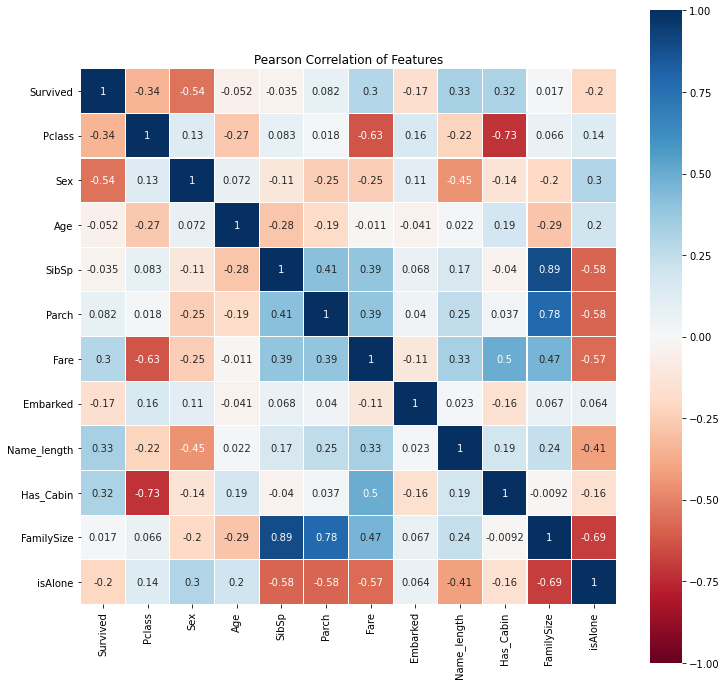

In [23]:
colormap = plt.cm.RdBu
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features')
sns.heatmap(train_df.astype(float).corr(), 
            linewidth=0.1 , vmin=-1 , vmax=1, 
             cmap = colormap, cbar=True, square=True, 
           linecolor='white', annot=True )

In [24]:
# Inferences from the graph
# Not many features are strongly correlated. each feature is unique and indenpendent 
# FamilySize and Parch, SibSp are strongly correlated since its derived from these features
train_df.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'Name_length', 'Has_Cabin', 'FamilySize', 'isAlone'],
      dtype='object')

<Figure size 576x576 with 0 Axes>

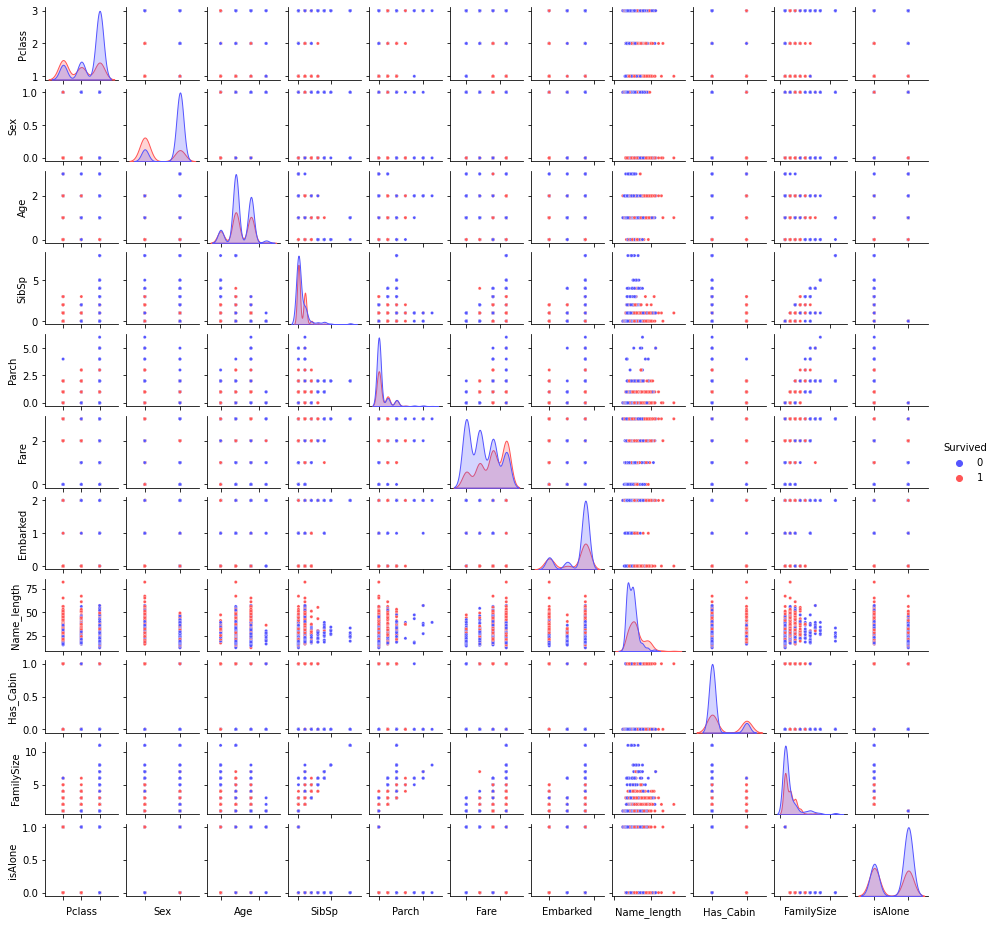

In [25]:
# Pairplots
plt.figure(figsize=(8,8))
cols = ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'Name_length', 'Has_Cabin', 'FamilySize', 'isAlone']
g = sns.pairplot(train_df[cols], hue='Survived', palette= 'seismic',
            height=1.2, diag_kind='kde', diag_kws= dict(shade=True), plot_kws= dict(s=10) )
g.set(xticklabels=[])
plt.show()

In [26]:
#Observe how hue colors help us differentiate 
#how certain certain categories and numerical ranges determines a person's survival rate

In [27]:
print(test_df.shape[0])
print(train_df.shape[0])

418
891


Ensembling and Stacking Models

In [28]:
ntrain = train_df.shape[0]  #891
ntest = test_df.shape[0]    #418
SEED=0
NFOLDS = 5
kf = KFold(n_splits=NFOLDS, shuffle=True, random_state=SEED)
class SKLearnHelper(object):
    def __init__( self, clf, seed=SEED, params=None ):
        params['random_state'] = seed
        self.clf = clf(**params)
        
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
        
    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self, x,y):
        return self.clf.fit(x,y)
    
    def feature_importance(self, x,y):
        print(self.clf.fit(x,y).feature_importances_)

In [29]:
def get_oof( clf, x_train, y_train, x_test ):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))
    #print("ooftrain", oof_train.shape)
    #print("oof_test", oof_test.shape)
    #print("ooftestskf", oof_test_skf.shape)
    
    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        #print("-------------",i, "th iteration-------------")
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        #print("xtr", x_tr.shape)
        #print("ytr", y_tr.shape)
        #print("xte", x_te.shape)
        
        clf.train(x_tr, y_tr)
        
        oof_train[test_index] = clf.predict(x_te)
        #print("ooftrain data", oof_train[test_index].shape)
        oof_test_skf[i,:] = clf.predict(x_test)
        #print("oof_testskfdata", oof_test_skf[i,:].shape)
        
    oof_test[:] = oof_test_skf.mean(axis=0)
    #print(oof_test.shape)
    #print(oof_test)
    return oof_train.reshape(-1,1), oof_test.reshape(-1,1)

In [30]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

In [31]:
# Create 5 objects that represent our 4 models
rf = SKLearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SKLearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SKLearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SKLearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SKLearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [32]:
y_train = train_df['Survived'].ravel()
train_df = train_df.drop(['Survived'], axis=1)
x_train = train_df.values
x_test = test_df.values

In [33]:
np.zeros(8,)

array([0., 0., 0., 0., 0., 0., 0., 0.])

In [34]:
x_test.shape
x_train.shape

(891, 11)

In [35]:
tets = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
tets

array([[1, 2],
       [3, 4],
       [1, 2],
       [3, 4]])

In [36]:
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

print("Training is complete")

Training is complete


In [37]:
print(et_oof_train.shape)
print(et_oof_test.shape)

(891, 1)
(418, 1)


In [38]:
et_oof_train[:10]

array([[0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.]])

In [39]:
et_oof_test[:10]

array([[0. ],
       [0.4],
       [0. ],
       [0. ],
       [0.2],
       [0. ],
       [1. ],
       [0. ],
       [1. ],
       [0. ]])

In [40]:
rf_feature = rf.feature_importance(x_train,y_train)
et_feature = et.feature_importance(x_train, y_train)
ada_feature = ada.feature_importance(x_train, y_train)
gb_feature = gb.feature_importance(x_train,y_train)

[0.10628906 0.39572688 0.04681946 0.03271066 0.02534901 0.05524839
 0.03498893 0.17338725 0.06226382 0.05346235 0.01375419]
[0.123098   0.47804238 0.0411596  0.02524212 0.02092464 0.06608947
 0.03321318 0.05994333 0.09070602 0.03859236 0.02298891]
[0.022 0.01  0.018 0.032 0.068 0.034 0.016 0.694 0.006 0.098 0.002]
[0.10999289 0.37778255 0.06501227 0.02342335 0.01494898 0.05525018
 0.03448935 0.20503762 0.04786055 0.05971037 0.00649189]


In [41]:
#features importances length = 11(# of features)

In [42]:
rf_features = [0.1099325 , 0.38842906 ,0.05051735 ,0.03301734, 0.02468269, 0.0545047,
 0.0333717 , 0.17764439, 0.06193978 ,0.05224701, 0.01371347]

et_features = [0.12588186, 0.48572914 ,0.04024693 ,0.02395804 ,0.01984367 ,0.06303976,
 0.03262119, 0.06084042, 0.08946576, 0.03588356, 0.02248967]

ada_features = [0.024, 0.01,  0.016, 0.024, 0.06,  0.026, 0.006, 0.736, 0.008, 0.084, 0.006]

gb_features = [0.12181572, 0.37415408, 0.05625991, 0.02481219, 0.01626952, 0.05145674,
 0.03533185, 0.20838916, 0.04709524, 0.0587445,  0.00567109]

In [43]:
cols = train_df.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_features,
     'Extra Trees  feature importances': et_features,
      'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gb_features
    })

In [44]:
feature_dataframe

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances
0,Pclass,0.109933,0.125882,0.024,0.121816
1,Sex,0.388429,0.485729,0.010,0.374154
2,Age,0.050517,0.040247,0.016,0.056260
3,SibSp,0.033017,0.023958,0.024,0.024812
4,Parch,0.024683,0.019844,0.060,0.016270
5,Fare,0.054505,0.063040,0.026,0.051457
6,Embarked,0.033372,0.032621,0.006,0.035332
7,Name_length,0.177644,0.060840,0.736,0.208389
8,Has_Cabin,0.061940,0.089466,0.008,0.047095
9,FamilySize,0.052247,0.035884,0.084,0.058744


In [65]:
feature_dataframe.iloc[:,1]

0     0.109933
1     0.388429
2     0.050517
3     0.033017
4     0.024683
5     0.054505
6     0.033372
7     0.177644
8     0.061940
9     0.052247
10    0.013713
Name: Random Forest feature importances, dtype: float64

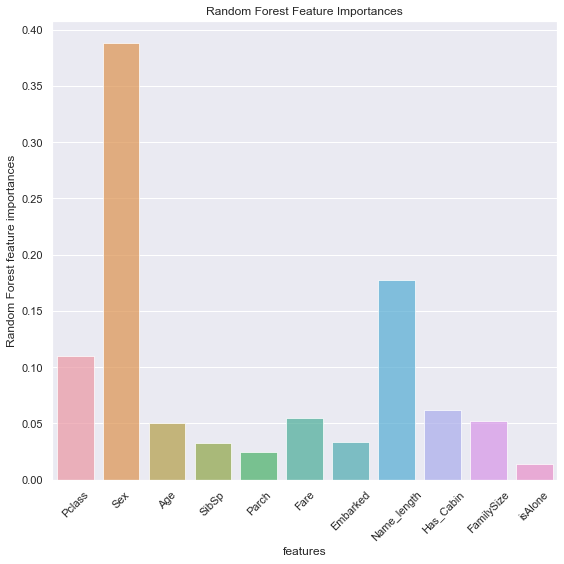

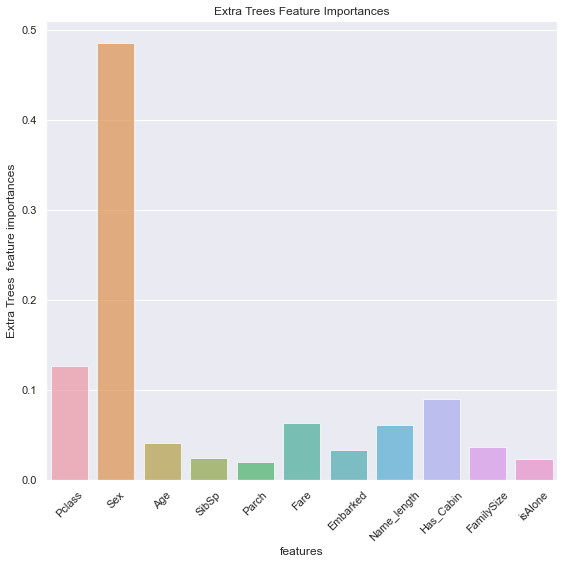

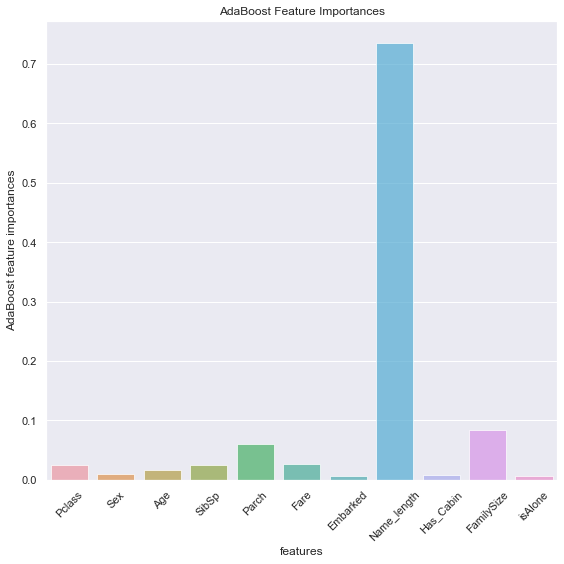

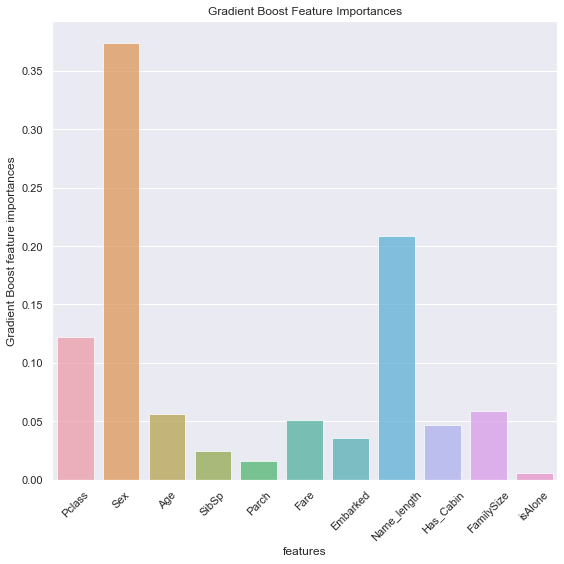

In [73]:
sns.set(rc={'figure.figsize':(8,8)})
plt.title("Random Forest Feature Importances")
sns.barplot(x=feature_dataframe.iloc[:,0], y=feature_dataframe.iloc[:,1],alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.title("Extra Trees Feature Importances")
sns.barplot(x=feature_dataframe.iloc[:,0], y=feature_dataframe.iloc[:,2],alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.title("AdaBoost Feature Importances")
sns.barplot(x=feature_dataframe.iloc[:,0], y=feature_dataframe.iloc[:,3],alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.title("Gradient Boost Feature Importances")
sns.barplot(x=feature_dataframe.iloc[:,0], y=feature_dataframe.iloc[:,4],alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [74]:
# # Scatter plot 
# trace = go.Scatter(
#     y = feature_dataframe['Random Forest feature importances'].values,
#     x = feature_dataframe['features'].values,
#     mode='markers',
#     marker=dict(
#         sizemode = 'diameter',
#         sizeref = 1,
#         size = 25,
# #       size= feature_dataframe['AdaBoost feature importances'].values,
#         #color = np.random.randn(500), #set color equal to a variable
#         color = feature_dataframe['Random Forest feature importances'].values,
#         colorscale='Portland',
#         showscale=True
#     ),
#     text = feature_dataframe['features'].values
# )
# data = [trace]

# layout= go.Layout(
#     autosize= True,
#     title= 'Random Forest Feature Importance',
#     hovermode= 'closest',
# #     xaxis= dict(
# #         title= 'Pop',
# #         ticklen= 5,
# #         zeroline= False,
# #         gridwidth= 2,
# #     ),
#     yaxis=dict(
#         title= 'Feature Importance',
#         ticklen= 5,
#         gridwidth= 2
#     ),
#     showlegend= False
# )
# fig = go.Figure(data=data, layout=layout)
# py.iplot(fig,filename='scatter2010')

# # Scatter plot 
# trace = go.Scatter(
#     y = feature_dataframe['Extra Trees  feature importances'].values,
#     x = feature_dataframe['features'].values,
#     mode='markers',
#     marker=dict(
#         sizemode = 'diameter',
#         sizeref = 1,
#         size = 25,
# #       size= feature_dataframe['AdaBoost feature importances'].values,
#         #color = np.random.randn(500), #set color equal to a variable
#         color = feature_dataframe['Extra Trees  feature importances'].values,
#         colorscale='Portland',
#         showscale=True
#     ),
#     text = feature_dataframe['features'].values
# )
# data = [trace]

# layout= go.Layout(
#     autosize= True,
#     title= 'Extra Trees Feature Importance',
#     hovermode= 'closest',
# #     xaxis= dict(
# #         title= 'Pop',
# #         ticklen= 5,
# #         zeroline= False,
# #         gridwidth= 2,
# #     ),
#     yaxis=dict(
#         title= 'Feature Importance',
#         ticklen= 5,
#         gridwidth= 2
#     ),
#     showlegend= False
# )
# fig = go.Figure(data=data, layout=layout)
# py.iplot(fig,filename='scatter2010')

# # Scatter plot 
# trace = go.Scatter(
#     y = feature_dataframe['AdaBoost feature importances'].values,
#     x = feature_dataframe['features'].values,
#     mode='markers',
#     marker=dict(
#         sizemode = 'diameter',
#         sizeref = 1,
#         size = 25,
# #       size= feature_dataframe['AdaBoost feature importances'].values,
#         #color = np.random.randn(500), #set color equal to a variable
#         color = feature_dataframe['AdaBoost feature importances'].values,
#         colorscale='Portland',
#         showscale=True
#     ),
#     text = feature_dataframe['features'].values
# )
# data = [trace]

# layout= go.Layout(
#     autosize= True,
#     title= 'AdaBoost Feature Importance',
#     hovermode= 'closest',
# #     xaxis= dict(
# #         title= 'Pop',
# #         ticklen= 5,
# #         zeroline= False,
# #         gridwidth= 2,
# #     ),
#     yaxis=dict(
#         title= 'Feature Importance',
#         ticklen= 5,
#         gridwidth= 2
#     ),
#     showlegend= False
# )
# fig = go.Figure(data=data, layout=layout)
# py.iplot(fig,filename='scatter2010')

# # Scatter plot 
# trace = go.Scatter(
#     y = feature_dataframe['Gradient Boost feature importances'].values,
#     x = feature_dataframe['features'].values,
#     mode='markers',
#     marker=dict(
#         sizemode = 'diameter',
#         sizeref = 1,
#         size = 25,
# #       size= feature_dataframe['AdaBoost feature importances'].values,
#         #color = np.random.randn(500), #set color equal to a variable
#         color = feature_dataframe['Gradient Boost feature importances'].values,
#         colorscale='Portland',
#         showscale=True
#     ),
#     text = feature_dataframe['features'].values
# )
# data = [trace]

# layout= go.Layout(
#     autosize= True,
#     title= 'Gradient Boosting Feature Importance',
#     hovermode= 'closest',
# #     xaxis= dict(
# #         title= 'Pop',
# #         ticklen= 5,
# #         zeroline= False,
# #         gridwidth= 2,
# #     ),
#     yaxis=dict(
#         title= 'Feature Importance',
#         ticklen= 5,
#         gridwidth= 2
#     ),
#     showlegend= False
# )
# fig = go.Figure(data=data, layout=layout)
# py.iplot(fig,filename='scatter2010')

In [46]:
feature_dataframe.head(10)

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances
0,Pclass,0.109933,0.125882,0.024,0.121816
1,Sex,0.388429,0.485729,0.010,0.374154
2,Age,0.050517,0.040247,0.016,0.056260
3,SibSp,0.033017,0.023958,0.024,0.024812
4,Parch,0.024683,0.019844,0.060,0.016270
5,Fare,0.054505,0.063040,0.026,0.051457
6,Embarked,0.033372,0.032621,0.006,0.035332
7,Name_length,0.177644,0.060840,0.736,0.208389
8,Has_Cabin,0.061940,0.089466,0.008,0.047095
9,FamilySize,0.052247,0.035884,0.084,0.058744


In [47]:
# Create the new column containing the average of values

feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe.head(3)

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
0,Pclass,0.109933,0.125882,0.024,0.121816,0.095408
1,Sex,0.388429,0.485729,0.010,0.374154,0.314578
2,Age,0.050517,0.040247,0.016,0.056260,0.040756


In [48]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
#data = [go.Bar(
#            x= x,
#             y= y,
#            width = 0.5,
#            marker=dict(
#               color = feature_dataframe['mean'].values,
#            colorscale='Portland',
#            showscale=True,
#            reversescale = False
#            ),
#            opacity=0.6
#        )]

#layout= go.Layout(
#    autosize= True,
#    title= 'Barplots of Mean Feature Importance',
#    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
#    yaxis=dict(
#        title= 'Feature Importance',
#        ticklen= 5,
#        gridwidth= 2
#    ),
##    showlegend= False
#)
#fig = go.Figure(data=data, layout=layout)
#py.iplot(fig, filename='bar-direct-labels')

[Text(0, 0, 'Pclass'),
 Text(1, 0, 'Sex'),
 Text(2, 0, 'Age'),
 Text(3, 0, 'SibSp'),
 Text(4, 0, 'Parch'),
 Text(5, 0, 'Fare'),
 Text(6, 0, 'Embarked'),
 Text(7, 0, 'Name_length'),
 Text(8, 0, 'Has_Cabin'),
 Text(9, 0, 'FamilySize'),
 Text(10, 0, 'isAlone')]

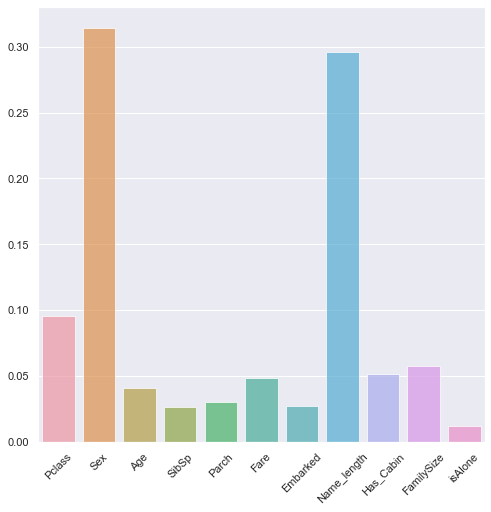

In [49]:
sns.set(rc={'figure.figsize':(8,8)})
ax=sns.barplot(x=x, y=y,alpha=0.7)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

Second-Level Predicitions from the First-Level Output

In [50]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel()
    })
print(base_predictions_train.shape)
base_predictions_train.head(10)

(891, 4)


,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0
8,1.0,1.0,1.0,1.0
9,1.0,1.0,1.0,1.0


Correlation Heatmap of Second Level Training Set

In [51]:
data = [
    go.Heatmap(
        z= base_predictions_train.astype(float).corr().values ,
        x=base_predictions_train.columns.values,
        y= base_predictions_train.columns.values,
          colorscale='Viridis',
            showscale=True,
            reversescale = True
    )
]
py.iplot(data, filename='labelled-heatmap')

<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

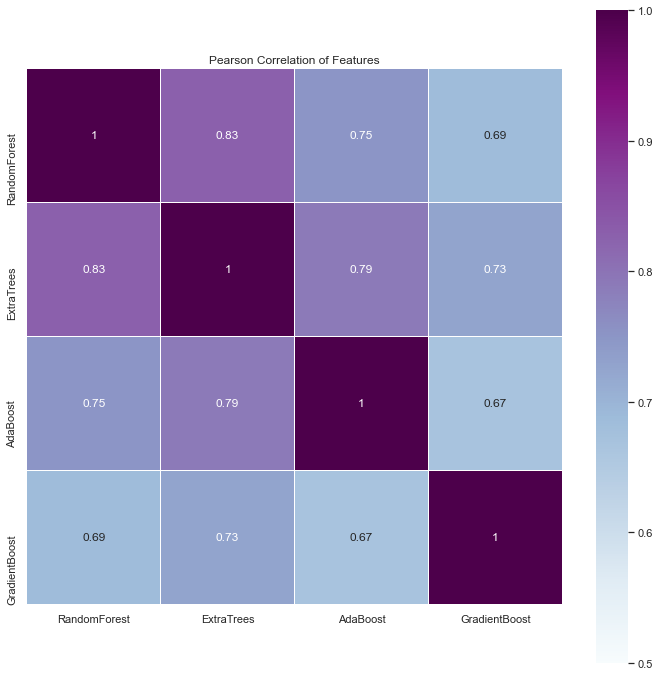

In [61]:
corrMatrix = base_predictions_train.corr()
colormap = "BuPu"
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features')
sns.heatmap(corrMatrix, 
            linewidth=0.1 , vmin=0.5 , vmax=1, 
             cmap = colormap, cbar=True, square=True, 
           linecolor='white', annot=True )

In [53]:
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

In [54]:
print(x_train.shape)
print(x_test.shape)

(891, 5)
(418, 5)


Second Level Learning Model via XGBoost

In [55]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)

[13:55:53] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [56]:
# Generate Submission File 
StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': predictions })
StackingSubmission.to_csv("StackingSubmission.csv", index=False)

# The End
PS : I learned a lot :)